# gpytorch for SingleTask GP

Separate models for all outputs

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from botorch.utils.transforms import unnormalize, normalize
import gpytorch
from botorch.models.transforms.outcome import Standardize
from torch.optim import Adam
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read and normalize data

In [2]:
filename = r'../data/olhs_combine.xlsx'
x_pd = pd.read_excel(filename, sheet_name='Design', header=[0,1], index_col=[0])
y_pd = pd.read_excel(filename, sheet_name='bo_data', header=[0,1], index_col=[0])

dtype=torch.double

objective_properties = ['Polymer Solubility', 'Gelation Enthalpy', 'Shear Modulus']

x_np = x_pd.values
y_np = y_pd[objective_properties].values

x = torch.tensor(x_np, dtype=dtype)
y = torch.tensor(y_np, dtype=dtype)

x_bounds = np.array([[2000, 10000], [0, 100], [0, 40], [5000, 15000], [80, 100], [0,100], [60, 100], [70, 100]])
x_bounds = torch.tensor(x_bounds.T, dtype=dtype)

x = normalize(x, bounds=x_bounds)

outcome_transform = Standardize(m=3)
y = outcome_transform(y)[0]

In [3]:
# identify non-feasible designs
mfg = y_pd['Manufacturability'].values
feas_bool = mfg==1
x = x[feas_bool.flatten(), :] 
y = y[feas_bool.flatten(), :]

Define model class

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
models = []
likelihoods = []

for i in range(len(objective_properties)):
    likelihoods.append(
        gpytorch.likelihoods.GaussianLikelihood()
    )
    models.append(
        ExactGPModel(train_x=x, train_y=y[:, i], likelihood=likelihoods[i])
    )
model = gpytorch.models.IndependentModelList(*models)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihoods)

In [6]:
mll = SumMarginalLogLikelihood(likelihood, model)

Fit the model

In [14]:
model.train()
likelihood.train()

optimizer = Adam(model.parameters(), lr=0.1)
loss_history = []

for i in range(500):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    loss_history.append(loss.item())
    optimizer.step()

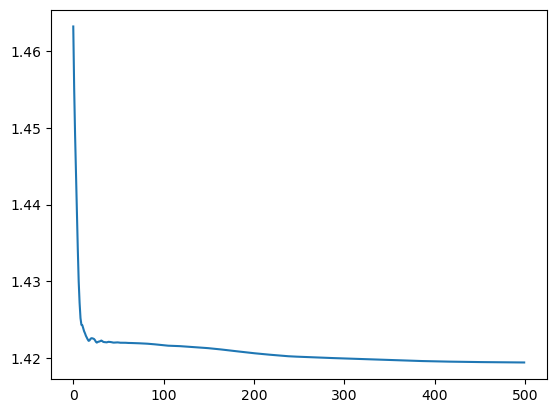

In [15]:
plt.plot(loss_history)
plt.show()

Predictions

In [16]:
model.eval()
likelihood.eval()

with torch.no_grad():
    posterior = likelihood(*model(x, x, x))

c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


## K-fold cross validation

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
data_split = kfold.split(range(len(x)))

train_r2_list = []
val_mape_list = []
val_r2_list = []
all_r2_list = []

for train_index, test_index in data_split:
    # train model
    x_train, y_train = x[train_index, :], y[train_index, :]
    x_val, y_val = x[test_index, :], y[test_index, :]

    models = []
    likelihoods = []

    for i in range(len(objective_properties)):
        likelihoods.append(
            gpytorch.likelihoods.GaussianLikelihood()
        )
        models.append(
            ExactGPModel(train_x=x_train, train_y=y_train[:, i], likelihood=likelihoods[i])
        )
    model = gpytorch.models.IndependentModelList(*models)
    likelihood = gpytorch.likelihoods.LikelihoodList(*likelihoods)
    mll = SumMarginalLogLikelihood(likelihood, model)

    # fit models
    
    model.train()
    likelihood.train()

    optimizer = Adam(model.parameters(), lr=0.1)
    loss_history = []

    for i in range(500):
        optimizer.zero_grad()
        output = model(*model.train_inputs)
        loss = -mll(output, model.train_targets)
        loss.backward()
        loss_history.append(loss.item())
        optimizer.step()

    # evaluate
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        posterior = likelihood(*model(x_train, x_train, x_train))
    pred_mean_all = torch.zeros((len(x_train), 3))
    for i in range(3):
        tmp_ = posterior[i].mean
        pred_mean_all[:, i] = tmp_
    train_r2_list.append(r2_score(y_true=y_train, y_pred=pred_mean_all))

    with torch.no_grad():
        posterior = likelihood(*model(x_val, x_val, x_val))
    pred_mean_all = torch.zeros((len(x_val), 3))
    for i in range(3):
        tmp_ = posterior[i].mean
        pred_mean_all[:, i] = tmp_
    val_r2_list.append(r2_score(y_true=y_val, y_pred=pred_mean_all))

    with torch.no_grad():
        posterior = likelihood(*model(x, x, x))
    pred_mean_all = torch.zeros((32, 3))
    for i in range(3):
        tmp_ = posterior[i].mean
        pred_mean_all[:, i] = tmp_
    all_r2_list.append(r2_score(y_true=y, y_pred=pred_mean_all))


c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
c:\Users\goura\anaconda3\envs\botorch\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train(

In [11]:
all_r2_list

[0.636781322050666,
 0.7227273837505339,
 0.45029213628474735,
 0.42012415367761147,
 0.7944212256729214]

In [12]:
all_r2_list = np.array(all_r2_list)
print("Average R2 score 5-fold cross validation = ", all_r2_list.mean())

Average R2 score 5-fold cross validation =  0.604869244287296


Average R2 score lower than BOTorch SingleTaskGP